##### Load Data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

os.chdir('/content/drive/MyDrive/databowl/')
df = pd.read_csv('2023_tracking.csv')

In [ ]:
play_ids = df['play_id_n'].unique()[2000:4500]
df = df[df['play_id_n'].isin(play_ids)]

In [ ]:
max_targets = df.groupby(['play_id_n', 'frame_id'])['player_to_predict'].sum().max()
print(max_targets)

8


##### Tabular to Pixel

In [ ]:
def pixel_map(player_data, target_player_ids, max_targets, grid_width=121, grid_height=55, sigma=.8):

    num_channels = 2 + max_targets + 1
    # three channels, one for offense, one for defense, one for ball location, one for player to predict
    pixel_map = np.zeros((num_channels, grid_height, grid_width), dtype=np.float32)

    x_vals = player_data['x'].values
    y_vals = player_data['y'].values

    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
        x_min = max(0, int(np.floor(x - 2*sigma)))
        x_max = min(grid_width, int(np.ceil(x + 2*sigma)) + 1)
        y_min = max(0, int(np.floor(y - 2*sigma)))
        y_max = min(grid_height, int(np.ceil(y + 2*sigma)) + 1)

        for xi in range(x_min, x_max):
            for yi in range(y_min, y_max):
                dist_sq = (xi - x)**2 + (yi - y)**2
                weight = np.exp(-dist_sq / (2 * sigma**2))

                player_id = player_data.iloc[i].get('nfl_id', None)

                if player_id in target_player_ids:
                    target_idx = target_player_ids.index(player_id)
                    if target_idx < max_targets: # to prevent error
                        pixel_map[2 + target_idx, yi, xi] += weight
                elif player_data.iloc[i]['player_side'] == 'Offense':
                    pixel_map[0, yi, xi] += weight
                elif player_data.iloc[i]['player_side'] == 'Defense':
                    pixel_map[1, yi, xi] += weight


    ball_x = player_data['ball_land_x'].iloc[0]
    ball_y = player_data['ball_land_y'].iloc[0]

    ball_x_min = max(0, int(np.floor(ball_x - 2*sigma)))
    ball_x_max = min(grid_width, int(np.ceil(ball_x + 2*sigma)) + 1)
    ball_y_min = max(0, int(np.floor(ball_y - 2*sigma)))
    ball_y_max = min(grid_height, int(np.ceil(ball_y + 2*sigma)) + 1)

    for xi in range(ball_x_min, ball_x_max):
        for yi in range(ball_y_min, ball_y_max):
            dist_sq = (xi - ball_x)**2 + (yi - ball_y)**2
            weight = np.exp(-dist_sq / (2 * sigma**2))
            pixel_map[2 + max_targets, yi, xi] += weight

    return pixel_map

testing one play

In [ ]:
df_play_id = df[df['play_id_n'] == 456]
target_player_ids = df_play_id[df_play_id['player_to_predict'] == True]['nfl_id'].unique().tolist()
df_grids_t = df_play_id.groupby(['play_id_n','frame_id']).apply(
    lambda x: pd.Series({'grid': pixel_map(x, target_player_ids, max_targets)})
)

C:\Users\dalto\AppData\Local\Temp\ipykernel_25552\2474093878.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grids_t = df_play_id.groupby(['play_id_n','frame_id']).apply(


grid for all plays

In [ ]:
df_grids = df.groupby(['play_id_n','frame_id']).apply(
    lambda x: pd.Series({'grid': pixel_map(x,  x[x['player_to_predict'] == True]['nfl_id'].unique().tolist(), max_targets)})
)

/tmp/ipython-input-3746108319.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grids = df.groupby(['play_id_n','frame_id']).apply(


In [ ]:
df_grids = df_grids.reset_index()
df_grids = df_grids.sort_values(['play_id_n', 'frame_id'])

visual test

In [ ]:
sample_grid = df_grids_t['grid'].iloc[30]

# Count how many target player channels have data
num_targets = 0
for i in range(max_targets):
    if sample_grid[2 + i].sum() > 0:
        num_targets += 1

# Create subplots: 2 base channels + ball + target players
total_plots = 3 + num_targets
cols = 4
rows = (total_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 5*rows))
axes = axes.flatten() if total_plots > 1 else [axes]

# Plot offense
axes[0].imshow(sample_grid[0], origin='lower', cmap='Reds')
axes[0].set_title('Offense Players')
axes[0].set_xlabel('X (yards)')
axes[0].set_ylabel('Y (yards)')

# Plot defense
axes[1].imshow(sample_grid[1], origin='lower', cmap='Blues')
axes[1].set_title('Defense Players')
axes[1].set_xlabel('X (yards)')
axes[1].set_ylabel('Y (yards)')

# Plot ball location (at index 2 + max_targets)
axes[2].imshow(sample_grid[2 + max_targets], origin='lower', cmap='Purples')
axes[2].set_title('Ball Landing Location')
axes[2].set_xlabel('X (yards)')
axes[2].set_ylabel('Y (yards)')

# Plot each target player (channels 2 through 2+max_targets-1)
plot_idx = 3
for i in range(max_targets):
    if sample_grid[2 + i].sum() > 0:
        axes[plot_idx].imshow(sample_grid[2 + i], origin='lower', cmap='Greens')
        axes[plot_idx].set_title(f'Target Player {i+1}')
        axes[plot_idx].set_xlabel('X (yards)')
        axes[plot_idx].set_ylabel('Y (yards)')
        plot_idx += 1

for idx in range(total_plots, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
df_grids.to_pickle("full_grids_2500.pkl")

### Transformer

##### Packages

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import gc
from transformers import get_cosine_schedule_with_warmup
df_grids = pd.read_pickle("full_grids_2500.pkl")
torch.manual_seed(26)

##### Inital Params

In [ ]:
max_targets = df.groupby(['play_id_n', 'frame_id'])['player_to_predict'].sum().max()
max_input = (df['frame_id'] - df['num_frames_output']).max()
max_output = (df['num_frames_output']).max()

##### Postional Encoder

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, dropout, max_length=150):
        super(PositionalEncoding, self).__init__()
        # droput
        self.dropout = nn.Dropout(p=dropout)

        # create matrix
        pe = torch.zeros(max_length, embed_size)

        # position tensor shape
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)

        # div_term tensor shape
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_size))

        # apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # apply cos to odd indices
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        # register as buffer so it moves with model to device
        self.register_buffer('pe', pe)

    def forward(self, x):
        pe_slice = self.pe[:x.size(1), :].to(x.device)
        x = x + pe_slice
        return self.dropout(x)

##### Encoding

In [ ]:
class CNN_DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # variable based on amount of targets
        input_chan = 2 + max_targets + 1

        # using stride rather than max pooling preforms better as max pooling tends to compress feat. too much.
        self.heatmap_encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_chan, out_channels=16, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(16), # normalize var and mean
            nn.GELU(), # preforms better on average idk if itll make a difference in this application

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU()
        )

    def forward(self, x):
        x = self.heatmap_encoder(x)
        return x


attention layer

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead, mask, dropout=0.15):
        super().__init__() # inhert from parent class

        if d_model % nhead != 0:
            raise ValueError(f"d_model ({d_model}) must be divisible by nhead ({nhead})")

        self.d_model = d_model # dimension of model
        self.nhead = nhead # number of attention heads, multi headed
        self.head_dim = d_model // nhead

        # create key query and values
        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        # learn context as a product of the attention heads
        self.out_proj = nn.Linear(d_model, d_model)
        # dropout as a form of regularzation
        self.dropout = nn.Dropout(dropout)
        # scaling function
        self.scale = self.head_dim ** -0.5

    def forward(self, x, mask=None):
        B, L, _ = x.shape # batch and length

        # create q, k, v values | init just random matrix mults, learned parameter
        qkv = self.qkv_proj(x)

        # split key, query, and value vectors into diff pares
        q, k, v = qkv.chunk(3, dim=-1)

        # transpose the matrix so that batch and nhead are treated as batches and self attention is calculated from there
        q = q.view(B, L, self.nhead, self.head_dim).transpose(1, 2)
        k = k.view(B, L, self.nhead, self.head_dim).transpose(1, 2)
        v = v.view(B, L, self.nhead, self.head_dim).transpose(1, 2)

        # scaled dot product, scale so values arent 0 or 1
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale # matrix mult

        # set masked values to -inf so softmax does not "give" attention to them
        if mask is not None:
          if mask.dim() == 2:
            mask = mask.expand(B, self.nhead, L, L)
          elif mask.dim() == 3:
            mask = mask.unsqueeze(1)
            mask = mask.expand(B, self.nhead, L, L)
          elif mask.dim() == 4:
            mask = mask.expand(B, self.nhead, L, L)

          scores = scores.masked_fill(mask == 0, -1e9)


        # softmax to give attention weights to each token
        attn_weights = torch.softmax(scores, dim=-1)

        # drop some weights
        attn_weights = self.dropout(attn_weights)

        # context vector for a given input sequence
        context = torch.matmul(attn_weights, v)

        # transpose so the matrix is in the correct size to be concatinated
        context = context.transpose(1, 2).contiguous().view(B, L, self.d_model)

        # "combine" the outputs from the head to one general vector
        output = self.out_proj(context)

        return output

transformer block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead=4, mask=None, dropout=0.15):
        super(TransformerBlock, self).__init__()
        # self attention class definied above
        self.self_attn = MultiHeadAttention(d_model=d_model, nhead=nhead, dropout=dropout, mask=mask)

        # feed forward network for each token
        self.feed_forward = nn.Sequential(
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Dropout(dropout), # to combat overfitting
            nn.Linear(128, 64)
        )

        # normilzations so values are between 0-1, learned gamma and beta parameters
        # to shift center and var for values.
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # standard dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        residual = x
        # normalized pre attention layer, gradients flow black directly without the normalizing effecting x values
        norm_x = self.norm1(x)
        # self attention
        attn_output = self.self_attn(norm_x, mask)
        # adding residual back to self attention
        x = residual + self.dropout(attn_output)

        residual = x
        # normalize values
        # we do so because over the amount of layers scale can get distorted, lead to super big or small values
        norm_x = self.norm2(x)
        # basic fcn
        ff_output = self.feed_forward(norm_x)
        # adding residual back so that the gradient can flow directly back.
        # adds a 1 + terms to gradients, helps solve the vanishing gradients problem
        x = residual + self.dropout(ff_output)

        return x

Encoder Block

In [ ]:
class TransEncoder(nn.Module):
    def __init__(self, input_dim, embed_size, num_layers, device, dropout, mask, max_length):
        super(TransEncoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        # learned matrix projection
        self.input_projection = nn.Linear(input_dim, embed_size)
        # postional encoding
        self.position_encoding = PositionalEncoding(embed_size, dropout, max_length)
        # layers of model, just stacked encoding layer
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    mask=mask,
                    nhead=4, # number of attention heads
                    dropout=dropout
                )
                for _ in range(num_layers)
            ]
        )
        # normalize after attention
        self.norm = nn.LayerNorm(embed_size)

    def forward(self, x, mask):
        # input layer matrix mult
        projected_input = self.input_projection(x)
        # position encodings
        out = self.position_encoding(projected_input)
        # mask to correct dim
        mask = mask.unsqueeze(1).unsqueeze(2)
        # pass through transformer block
        for layer in self.layers:
            out = layer(out, mask)
        # normalize gradients
        out = self.norm(out)

        return out

##### Masks

In [ ]:
# prevent lookahead
def create_causal_mask(seq_len, device):
    mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    return mask.bool()

# seq mask to deal with padded values
def seq_maks(input_lengths, max_input, device):
    batch_size = len(input_lengths)
    input_mask = torch.zeros(batch_size, max_input, device=device, dtype=torch.bool)
    for i, length in enumerate(input_lengths):
        input_mask[i, :length] = True

# loss with mask
def mse_with_length_mask(predictions, targets, combined_mask):
    mse = (predictions - targets) ** 2
    masked_mse = mse * combined_mask.float()

    valid_elements = combined_mask.sum()

    if valid_elements > 0:
        return masked_mse.sum() / valid_elements
    else:
        return torch.tensor(0.0, device=predictions.device)

##### Decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, dropout, embedding, nhead):
        super().__init__()
        # attention layers
        self.attention_self = MultiHeadAttention(d_model=embedding, nhead=4, mask=None, dropout=dropout)

        # cross atten, query values, info
        self.cross_q_proj = nn.Linear(embedding, embedding)
        self.cross_k_proj = nn.Linear(embedding, embedding)
        self.cross_v_proj =  nn.Linear(embedding, embedding)
        self.cross_out_proj = nn.Linear(embedding, embedding)

        self.nhead = nhead
        self.head_dim = embedding // nhead
        self.scale = self.head_dim ** -0.5 # 1/sqrt(dk)

        # layer normal
        self.norm1 = nn.LayerNorm(embedding)
        self.norm2 = nn.LayerNorm(embedding)
        self.norm3 = nn.LayerNorm(embedding)

        # droput
        self.dropout = nn.Dropout(dropout)

        # fcnn
        self.fcnn = nn.Sequential(
            nn.Linear(embedding, embedding*2),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.Linear(embedding*2, embedding)
        )
    # decoder forward pass
    def forward(self, decoder_input, encoded_context, target_mask = None, casual_mask=None):

        # self attention amoung decoder
        residual = decoder_input
        norm_x = self.norm1(decoder_input)
        self_attn = self.attention_self(norm_x, casual_mask)
        decoder_input = residual + self.dropout(self_attn)

        # cross attention to encoder
        norm_x = self.norm2(decoder_input)
        cross_atn = self.encoder_cross_attention(norm_x, encoded_context)
        # dropout, also cant do inplace ops bc of backprop
        decoder_input = decoder_input + self.dropout(cross_atn)

        # fcnn predictions
        norm_x = self.norm3(decoder_input)
        ffcn = self.fcnn(norm_x)
        out = decoder_input + self.dropout(ffcn)

        return out

    def encoder_cross_attention(self, query, key_value):
        B, L_q, _ = query.shape # decoder input
        B, L_kv, _ = key_value.shape # encoder output

        q = self.cross_q_proj(query)
        k = self.cross_k_proj(key_value)
        v = self.cross_v_proj(key_value)

        q = q.view(B, L_q, self.nhead, self.head_dim).transpose(1, 2)
        k = k.view(B, L_kv, self.nhead, self.head_dim).transpose(1, 2)
        v = v.view(B, L_kv, self.nhead, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = torch.matmul(attn_weights, v)
        context = context.transpose(1, 2).contiguous().view(B, L_q, -1)

        output = self.cross_out_proj(context)

        return output

Decoder block

In [ ]:
class TransDecoder(nn.Module):
    def __init__(self, target_mask, embedding, dropout, nhead, layers, max_targets, max_step_change, max_seq_len):
        super(TransDecoder, self).__init__()
        self.max_targets = max_targets
        self.max_seq_len = max_seq_len
        self.embedding = embedding
        self.max_step = max_step_change

        self.max_velocity = max_step_change if max_step_change else 1.35
        self.smoothing_factor = 0.8

        # project 2d cords to embedding space
        self.positon_projection = nn.Linear(2, embedding)

        # project outputs back to 2d space
        self.output_projection = nn.Linear(embedding, 2)

        # postional embeddings
        self.pos_embed = PositionalEncoding(embed_size=embedding, dropout=0.15, max_length=150)

        # decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(embedding=embedding, dropout=dropout, nhead=nhead)
            for _ in range(layers)
        ])

        # normalization
        self.norm = nn.LayerNorm(embedding)

    def smooth_velo(self, new_pos, current_pos, previous_pos=None):
        if previous_pos is None:
            delta = new_pos - current_pos
            velo = torch.norm(delta, p=2, dim=-1, keepdim=True)

            scale = torch.sigmoid(self.max_velocity - velo) * 0.5
            smoothed_delta = delta * scale
            return current_pos + smoothed_delta
        else:
            previous_velocity = current_pos - previous_pos
            predicted_delta = new_pos - current_pos

            velocity_change = predicted_delta - previous_velocity
            velocity_change_mag = torch.norm(velocity_change, p=2, dim=-1, keepdim=True)

            smooth_scale = torch.exp(-velocity_change_mag / self.max_velocity)
            smoothed_velocity = previous_velocity * self.smoothing_factor + predicted_delta * (1 - self.smoothing_factor)

            velocity_mag = torch.norm(smoothed_velocity, p=2, dim=-1, keepdim=True)
            final_scale = torch.min(torch.ones_like(velocity_mag), self.max_velocity / (velocity_mag + 1e-8))

            return current_pos + smoothed_velocity * final_scale

    def forward(self, encoded_context, start_positons, target_mask, max_step_change, output_lengths):
        # batch, max_seq, device
        batch_size = encoded_context.shape[0]
        device = encoded_context.device
        max_seq_len = self.max_seq_len

        # output tensor
        all_outputs = torch.zeros(batch_size, self.max_targets, max_seq_len, 2, device=device)

        # autoregressive 
        decoder_sequence = [[] for _ in range(batch_size)]
        current_postions = start_positons.clone()
        previous_pos = None

        # output sequence
        for step in range(max_seq_len):
            # project pos to embedding space
            pos_embeds = self.positon_projection(current_postions)

            # add positional context
            pos_encoding = self.pos_embed.pe[step, :self.embedding].unsqueeze(0).unsqueeze(0)
            # Replace inplace addition with out-of-place addition
            pos_input = pos_embeds + pos_encoding
            # add sequence dim back
            pos_input = pos_input.unsqueeze(2)

            # decoder seq
            for batch_idx in range(batch_size):
                decoder_sequence[batch_idx].append(pos_input[batch_idx])

            if step == 0:
                # if first step use init pos
                decoder_input = pos_input
                casual_mask = None
            else:
                # decoder inputs
                batch_decoder_inputs = []

                # get decoder seq for values
                for batch_idx in range(batch_size):
                    sample_sequence = torch.cat(decoder_sequence[batch_idx], dim = 1)
                    batch_decoder_inputs.append(sample_sequence)
                else: 
                    dummy_input = torch.zeros(self.max_targets, step+1, self.embedding, device=device)
                    batch_decoder_inputs.append(dummy_input)

                # all samples for decoder input
                decoder_input = torch.stack(batch_decoder_inputs)

                # casual mask
                seq_len = step + 1
                casual_mask = create_causal_mask(seq_len, device)


            # transformer layers
            batch_size_curr, max_targets_curr, seq_len_curr, embed_dim_curr = decoder_input.shape
            decoder_input_reshaped = decoder_input.view(batch_size_curr * max_targets_curr, seq_len_curr, embed_dim_curr)

            # decoder layer
            decoded = decoder_input_reshaped

            # masking for future seq
            if casual_mask is not None:
               casual_mask_expanded = casual_mask.unsqueeze(0).expand(batch_size_curr * max_targets_curr, seq_len_curr, seq_len_curr)
            else:
               casual_mask_expanded = None

            # pass through decoder layers
            expanded_context = encoded_context.unsqueeze(1).repeat(1, max_targets_curr, 1, 1)
            expanded_context = expanded_context.view(batch_size_curr * max_targets_curr, -1, self.embedding)

            for layer in self.layers:
                decoded = layer(decoded, expanded_context,target_mask, casual_mask_expanded)

            # normalize gradients
            decoded = self.norm(decoded)

            # reshape and project back to cords
            decoded = decoded.view(batch_size_curr, max_targets_curr, seq_len_curr, embed_dim_curr)
            predictions = self.output_projection(decoded[:, :, -1, :])

            # smooth velocity predictiosn 
            clamp_pred = self.smooth_velo(predictions, current_postions, previous_pos)

            # store every prediction
            all_outputs[:, :, step, :] = clamp_pred

            # stack all predictions
            previous_pos = current_postions.clone()
            current_postions = clamp_pred.clone()

        return all_outputs

##### Model

In [ ]:
class DJMooreSeq(nn.Module):
    def __init__(self, embed_size, encoder_layers, decoder_layers,
                 max_targets, dropout, nheads, max_step, dev='cuda') -> None:
        super().__init__()

        # general vars
        self.embedding_size = embed_size
        self.max_targets = max_targets
        self.device = dev

        # context cnn
        self.context_cnn = CNN_DownSample()
        context_cnn_output = 64* 7 * 16

        # transformer encoder
        self.encoder = TransEncoder(input_dim=context_cnn_output,
                                    embed_size=embed_size,
                                    num_layers=encoder_layers,
                                    device=dev,
                                    mask=None,
                                    dropout=dropout,
                                    max_length=150)

        # decoder
        self.decoder = TransDecoder(target_mask=None,
                                    embedding=embed_size,
                                    dropout=dropout,
                                    nhead=nheads,
                                    layers=decoder_layers,
                                    max_targets=max_targets,
                                    max_step_change=max_step,
                                    max_seq_len=max_output)

    def forward(self, heatmap_sequence, start_pos, target_mask, future_steps, input_lengths):
        # derive batch size, length of transformer output
        batch_size, seq_len = heatmap_sequence.shape[:2]
        
        # cnn features
        cnn_features = []
        for t in range(seq_len):
            frame = heatmap_sequence[:,t]
            features = self.context_cnn(frame)
            features = features.flatten(1)
            cnn_features.append(features)

        # stack and encode
        sequence_feat = torch.stack(cnn_features, dim=1)

        # encoder mask based on input seq
        encoder_mask = torch.zeros(batch_size, seq_len, device=heatmap_sequence.device, dtype=torch.bool)
        for i, length in enumerate(input_lengths):
            encoder_mask[i, :length] = True

        # context
        encoded_context = self.encoder(sequence_feat, encoder_mask)
        # output predictions
        predictions = self.decoder(encoded_context, start_pos, target_mask, future_steps, input_lengths)

        return predictions

##### Train Loop

In [ ]:
def train(model, train_loader, val_loader, loss_func, optimizer, scheduler, epochs):
  # scaler for amp
  scaler = torch.GradScaler(device="cuda")

  # loss
  train_losses = []
  val_losses = []
  # early stopping
  best_loss = np.inf
  early_stop_rounds = 0

  for epoch in range(epochs):
    # train mode, loss and batches
    model.train()
    epoch_loss = 0
    batches = 0

    for batch_sequence, batch_targets, batch_masks, batch_start_pos, batch_input_lengths, batch_output_lengths in train_loader:

        # move all items to gpu
        batch_sequence = batch_sequence.to('cuda')
        batch_targets = batch_targets.to('cuda')
        batch_masks = batch_masks.to('cuda')
        batch_start_pos = batch_start_pos.to('cuda')
        batch_input_lengths = batch_input_lengths.to('cuda')
        batch_output_lengths = batch_output_lengths.to('cuda')

        # zero the gradients
        optimizer.zero_grad()

        with torch.autocast(device_type="cuda"):
            # forward pass
            predictions = model(batch_sequence, batch_start_pos, batch_masks,
                                batch_output_lengths, batch_input_lengths)

            # train loss
            loss = loss_func(predictions, batch_targets, batch_masks, batch_output_lengths)

        # backprop
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # epoch loss
        epoch_loss += loss.item() * batch_sequence.size(0)
        batches += batch_sequence.size(0)

    # training losses
    avg_loss = epoch_loss / batches
    train_losses.append(avg_loss)

    # val set losses
    model.eval()
    val_epoch_loss = 0
    val_batches = 0

    with torch.no_grad():
        for val_sequence, val_targets, val_masks, val_start_pos, val_input_lengths, val_output_lengths in val_loader:
            # to cuda
            val_sequence = val_sequence.to('cuda')
            val_targets = val_targets.to('cuda')
            val_masks = val_masks.to('cuda')
            val_start_pos = val_start_pos.to('cuda')
            val_input_lengths = val_input_lengths.to('cuda')
            val_output_lengths = val_output_lengths.to('cuda')

            with torch.autocast(device_type='cuda'):
                # predictions and loss on val set
                val_predictions = model(val_sequence, val_start_pos, val_masks, val_output_lengths, val_input_lengths)

                # validtion losses
                val_loss = loss_func(val_predictions, val_targets, val_masks, val_output_lengths)

            val_epoch_loss += val_loss.item() * val_sequence.size(0)
            val_batches += val_sequence.size(0)

    # val set losses
    val_epoch_loss = val_epoch_loss / val_batches
    val_losses.append(val_epoch_loss)

    # learning rate sched.
    scheduler.step()

    print(f'val_loss {val_epoch_loss}, train_loss {avg_loss}')

    # early stopping check
    if val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        early_stop_rounds = 0
        torch.save(model.state_dict(), f"best_model.pth")
    else:
        early_stop_rounds += 1

    if early_stop_rounds > 20:
        print('early stopping')
        return train_losses, val_losses

  return train_losses, val_losses

##### Loss Function

In [ ]:
class MaskedSequenceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, predictions, targets, target_mask, output_len):
        batch_size, max_targets, max_seq_len, coords = predictions.shape

        if predictions.shape[2] != targets.shape[2]:
            raise ValueError("seq len mismatch")
        
        # len mask
        length_mask = torch.arange(max_seq_len, device=predictions.device)[None, :] < output_len[:, None]

        # masking
        target_mask_expanded = target_mask.unsqueeze(-1).unsqueeze(-1)
        length_mask_expanded = length_mask.unsqueeze(1).unsqueeze(-1)
        combined_mask = target_mask_expanded & length_mask_expanded
        combined_mask = combined_mask.expand_as(predictions)

        # mse
        mse = F.mse_loss(predictions, targets, reduction='None')

        # zero out invalid pos
        masked_mse = mse * combined_mask.float()

        # valid ele
        valid_elements = combined_mask.sum()

        if valid_elements > 0:
            return masked_mse.sum() / valid_elements
        else:
            return torch.tensor(0.0, device=predictions.device)


##### Data Loader

In [ ]:
# create dataset instance by instance rather than all at once
class NFLSequenceDataset(Dataset):
    def __init__(self, df_grids, df_tracking, max_targets, max_input, max_output, split_indices=None):
        # input vars
        self.df_grids = df_grids
        self.df_tracking = df_tracking
        self.max_targets = max_targets
        self.max_input = max_input
        self.max_output = max_output

        # play_ids
        self.play_ids = df_grids['play_id_n'].unique()
        if split_indices is not None:
            self.play_ids = self.play_ids[split_indices]

        # players to predict for each play
        self.player_to_predict = df_tracking[df_tracking['player_to_predict'] == True].groupby('play_id_n')['nfl_id'].unique()

    def __len__(self):
        # how many plays
        return len(self.play_ids)

    def __getitem__(self, idx):
        play_id = self.play_ids[idx]

        # data for a given play
        play_data = self.df_grids[self.df_grids['play_id_n'] == play_id].sort_values('frame_id')
        df_data = self.df_tracking[self.df_tracking['play_id_n'] == play_id]

        # seq lengths
        total_frames = play_data['frame_id'].max()
        output_frames = int(df_data['num_frames_output'].max())
        input_seq_len = total_frames - output_frames
        output_seq_len = output_frames

        # target play ids
        if play_id in self.player_to_predict:
            players = self.player_to_predict[play_id][:self.max_targets]
        else:
            players = []

        num_receivers = len(players)

        # mask for less than max target
        target_mask = torch.zeros(self.max_targets, dtype=torch.bool)
        target_mask[:num_receivers] = True

        # input seq
        input_sequence = torch.zeros(self.max_input, *play_data['grid'].iloc[0].shape, dtype=torch.float16)
        act_input = min(input_seq_len, self.max_input)

        for i in range(act_input):
            if i < total_frames:
                grid = torch.from_numpy(play_data['grid'].iloc[i]).float()
                input_sequence[i] = grid


        # start positons
        start_pos = torch.zeros(self.max_targets, 2)

        # last frame from dataset
        last_frame_id = input_seq_len.copy()

        last_frame_data = self.df_tracking[
            (self.df_tracking['play_id_n'] == play_id) &
            (self.df_tracking['frame_id'] == last_frame_id)
        ]

        # init postions fo start plyer
        for i, receiver_id in enumerate(players):
            receiver_data = last_frame_data[last_frame_data['nfl_id'] == receiver_id]
            if not receiver_data.empty:
                x = float(receiver_data['x'].iloc[0]) / 120
                y = float(receiver_data['y'].iloc[0]) / 53.3
                start_pos[i] = torch.tensor([x, y])


        # target seq
        target_positions = torch.zeros(self.max_targets, self.max_output, 2)
        act_output = min(output_frames, self.max_output)

        # target postions
        for step in range(act_output):
            frame_idx = input_seq_len + step

            if frame_idx < len(play_data):
                target_frame = play_data.iloc[frame_idx]['frame_id']
                target_frame_data = self.df_tracking[
                    (self.df_tracking['play_id_n'] == play_id) &
                    (self.df_tracking['frame_id'] == target_frame)
                ]

                for i, receiver_id in enumerate(players):
                    receiver_data = target_frame_data[target_frame_data['nfl_id'] == receiver_id]
                    if not receiver_data.empty:
                        x = float(receiver_data['x'].iloc[0]) / 120
                        y = float(receiver_data['y'].iloc[0]) / 53.3
                        target_positions[i, step] = torch.tensor([x, y])


        return (
            input_sequence,
            target_positions,
            target_mask,
            start_pos,
            torch.tensor(act_input),
            torch.tensor(act_output)
        )

##### Data Prep, Training, Testing

In [ ]:
# split by indexs
play_indices = np.arange(len(df_grids['play_id_n'].unique()))
train_idx, test_idx = train_test_split(play_indices, test_size=0.2, random_state=26)
test_idx, val_idx = train_test_split(test_idx, test_size=0.7, random_state=26)

# create the datasets dynamically
train_dataset = NFLSequenceDataset(df_grids, df, max_targets, int(max_input), int(max_output), train_idx)
val_dataset = NFLSequenceDataset(df_grids, df, max_targets, int(max_input), int(max_output), val_idx)
test_dataset = NFLSequenceDataset(df_grids, df, max_targets, int(max_input), int(max_output), test_idx)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
# clean envi
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# model
model = DJMooreSeq(embed_size=64, encoder_layers=4, decoder_layers=4, max_targets=max_targets, max_step=1.4, dropout=0.1, nheads=4,dev='cuda').to('cuda')

# epochs
epochs = 1000

# loss, opti, schedu
loss_func = MaskedSequenceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=5, num_training_steps=epochs)

# train
train_losses, val_losses = train(model, train_loader, val_loader, loss_func, optimizer, scheduler, epochs)

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 11.38 MiB is free. Process 10591 has 22.14 GiB memory in use. Of the allocated memory 21.34 GiB is allocated by PyTorch, and 582.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
state_dict = torch.load("2500_4_4_4_model26.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

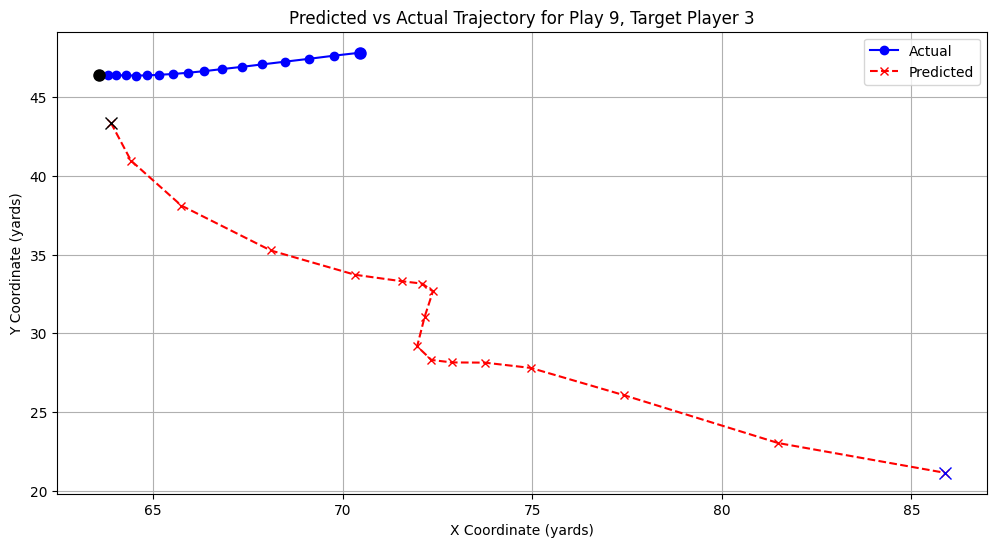

In [ ]:
def visualize_predictions(model, data_loader, play_idx=0, target_player_idx=0):

    model.eval()

    with torch.no_grad():
        for batch_sequence, batch_targets, batch_masks, batch_start_pos, batch_input_lengths, batch_output_lengths in data_loader:
            batch_sequence = batch_sequence.to('cuda')
            batch_targets = batch_targets.to('cuda')
            batch_masks = batch_masks.to('cuda')
            batch_start_pos = batch_start_pos.to('cuda')
            batch_input_lengths = batch_input_lengths.to('cuda')
            batch_output_lengths = batch_output_lengths.to('cuda')

            with torch.autocast(device_type="cuda"):
                predictions = model(batch_sequence, batch_start_pos, batch_masks,
                                    batch_output_lengths, batch_input_lengths)

            predicted_trajectory = predictions[play_idx, target_player_idx, :, :].cpu().numpy()
            actual_trajectory = batch_targets[play_idx, target_player_idx, :, :].cpu().numpy()
            mask = batch_masks[play_idx, target_player_idx].cpu().numpy()
            output_length = batch_output_lengths[play_idx].cpu().numpy()


            predicted_trajectory = predicted_trajectory[:output_length]
            actual_trajectory = actual_trajectory[:output_length]

            # scale back to normal 
            predicted_trajectory[:, 0] *= 120
            predicted_trajectory[:, 1] *= 53.3
            actual_trajectory[:, 0] *= 120
            actual_trajectory[:, 1] *= 53.3

            # plot trajectory
            plt.figure(figsize=(12, 6))
            plt.plot(actual_trajectory[:, 0], actual_trajectory[:, 1], marker='o', linestyle='-', color='blue', label='Actual')
            plt.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], marker='x', linestyle='--', color='red', label='Predicted')
            plt.xlabel('X Coordinate (yards)')
            plt.ylabel('Y Coordinate (yards)')
            plt.title(f'Predicted vs Actual Trajectory for Play {play_idx}, Target Player {target_player_idx}')
            plt.legend()
            plt.grid(True)

            # first point in black
            plt.plot(actual_trajectory[0, 0], actual_trajectory[0, 1], marker='o', color='black', markersize=8)
            plt.plot(predicted_trajectory[0, 0], predicted_trajectory[0, 1], marker='x', color='black', markersize=8)

            # last point blue
            plt.plot(actual_trajectory[-1, 0], actual_trajectory[-1, 1], marker='o', color='blue', markersize=8)
            plt.plot(predicted_trajectory[-1, 0], predicted_trajectory[-1, 1], marker='x', color='blue', markersize=8)

            plt.show()

            break

visualize_predictions(model, test_loader, play_idx=9, target_player_idx=3)